# QB time-to-throw vs. 49ers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from scipy.interpolate import make_interp_spline, BSpline

import csaps


sns.set(style="whitegrid", 
        palette="pastel", 
        font='Circular Spotify Text', 
        font_scale = 1.1, 
        rc= {'grid.color': '.95', 'xtick.color': '.3', 'ytick.color': '.3'})


## Reading data

In [3]:
df = pd.read_csv("../data/nflscrapR/reg_pbp_2019.csv")
df = pd.concat([df, pd.read_csv("../data/nflscrapR/reg_pbp_2018.csv")])
df = pd.concat([df, pd.read_csv("../data/nflscrapR/reg_pbp_2017.csv")])

df_ngs = pd.read_csv("../data/ngs-spider/passing/ngs_passing_2019_reg.csv", index_col=[0])
df_ngs = pd.concat([df_ngs, pd.read_csv("../data/ngs-spider/passing/ngs_passing_2018_reg.csv", index_col=[0])])
df_ngs = pd.concat([df_ngs, pd.read_csv("../data/ngs-spider/passing/ngs_passing_2017_reg.csv", index_col=[0])])

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (167,168,191,192,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_ngs.head()

,shortName,playerName,team,aggressiveness,attempts,avgAirYardsDifferential,avgAirYardsToSticks,avgCompletedAirYards,avgIntendedAirYards,avgTimeToThrow,...,expectedCompletionPercentage,interceptions,maxCompletedAirDistance,passTouchdowns,passYards,passerRating,season,seasonType,week,gameId
0,C.Keenum,Case Keenum,WAS,13.6,44,-1.4,-3.0,5.9,7.4,2.85,...,65.0,0,50.2,3,380,117.6,2019,REG,1,2019090806
1,C.Wentz,Carson Wentz,PHI,12.8,39,-0.9,-0.2,7.7,8.6,2.57,...,68.1,0,58.4,3,313,121.0,2019,REG,1,2019090806
2,B.Roethlisberger,Ben Roethlisberger,PIT,12.8,47,-5.0,0.1,4.6,9.6,2.54,...,63.9,1,53.0,0,276,65.6,2019,REG,1,2019090812
3,C.Newton,Cam Newton,CAR,13.2,38,-1.4,-2.4,4.9,6.3,2.24,...,71.8,1,33.7,0,239,72.1,2019,REG,1,2019090800
4,J.Garoppolo,Jimmy Garoppolo,SF,14.8,27,-3.0,-5.7,2.2,5.2,2.31,...,72.1,1,37.7,1,166,80.2,2019,REG,1,2019090811


In [5]:
sf_games = (df.loc[(df['home_team'] == 'SF') | (df['away_team'] == 'SF'), ['game_id', 'home_team', 'away_team']].drop_duplicates())

sf_games.loc[sf_games['home_team'] != 'SF', 'opponent'] = sf_games['home_team']
sf_games.loc[sf_games['away_team'] != 'SF', 'opponent'] = sf_games['away_team']

sf_games.head()


,game_id,home_team,away_team,opponent
1759,2019090811,TB,SF,TB
3932,2019091501,CIN,SF,CIN
7650,2019092212,SF,PIT,PIT
13740,2019100700,SF,CLE,CLE
942,2018090904,MIN,SF,MIN


In [6]:
df_ngs = df_ngs.rename(columns = {'gameId' : 'game_id', 'team': 'opponent'})
df_ngs.head()

,shortName,playerName,opponent,aggressiveness,attempts,avgAirYardsDifferential,avgAirYardsToSticks,avgCompletedAirYards,avgIntendedAirYards,avgTimeToThrow,...,expectedCompletionPercentage,interceptions,maxCompletedAirDistance,passTouchdowns,passYards,passerRating,season,seasonType,week,game_id
0,C.Keenum,Case Keenum,WAS,13.6,44,-1.4,-3.0,5.9,7.4,2.85,...,65.0,0,50.2,3,380,117.6,2019,REG,1,2019090806
1,C.Wentz,Carson Wentz,PHI,12.8,39,-0.9,-0.2,7.7,8.6,2.57,...,68.1,0,58.4,3,313,121.0,2019,REG,1,2019090806
2,B.Roethlisberger,Ben Roethlisberger,PIT,12.8,47,-5.0,0.1,4.6,9.6,2.54,...,63.9,1,53.0,0,276,65.6,2019,REG,1,2019090812
3,C.Newton,Cam Newton,CAR,13.2,38,-1.4,-2.4,4.9,6.3,2.24,...,71.8,1,33.7,0,239,72.1,2019,REG,1,2019090800
4,J.Garoppolo,Jimmy Garoppolo,SF,14.8,27,-3.0,-5.7,2.2,5.2,2.31,...,72.1,1,37.7,1,166,80.2,2019,REG,1,2019090811


In [7]:
data = sf_games[['game_id', 'opponent']].merge(df_ngs, how='left', on=['game_id', 'opponent'])
data['game'] = data.groupby(['season']).cumcount('game_id') + 1

data.columns

Index(['game_id', 'opponent', 'shortName', 'playerName', 'aggressiveness',
       'attempts', 'avgAirYardsDifferential', 'avgAirYardsToSticks',
       'avgCompletedAirYards', 'avgIntendedAirYards', 'avgTimeToThrow',
       'completionPercentage', 'completionPercentageAboveExpectation',
       'expectedCompletionPercentage', 'interceptions',
       'maxCompletedAirDistance', 'passTouchdowns', 'passYards',
       'passerRating', 'season', 'seasonType', 'week', 'game'],
      dtype='object')

In [16]:
data.loc[data['season'] == 2019]

,game_id,opponent,shortName,playerName,aggressiveness,attempts,avgAirYardsDifferential,avgAirYardsToSticks,avgCompletedAirYards,avgIntendedAirYards,...,expectedCompletionPercentage,interceptions,maxCompletedAirDistance,passTouchdowns,passYards,passerRating,season,seasonType,week,game
0,2019090811,TB,J.Winston,Jameis Winston,19.4,36,-3.6,-0.7,5.1,8.7,...,60.6,3,29.6,1,194,45.4,2019,REG,1,1
1,2019091501,CIN,A.Dalton,Andy Dalton,14.3,42,-2.8,-1.8,4.4,7.2,...,70.4,1,38.0,2,311,90.5,2019,REG,2,2
2,2019092212,PIT,M.Rudolph,Mason Rudolph,33.3,27,-4.8,-2.0,2.3,7.1,...,58.1,1,49.1,2,174,81.4,2019,REG,3,3
3,2019100700,CLE,B.Mayfield,Baker Mayfield,18.2,22,-5.3,2.2,7.0,12.4,...,55.2,2,37.2,0,100,13.4,2019,REG,5,4


In [8]:
pal = sns.light_palette((370, 90, 55), input="husl")[2:5]

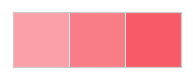

In [9]:
sns.palplot(pal)

In [10]:
sns.set_palette(pal)

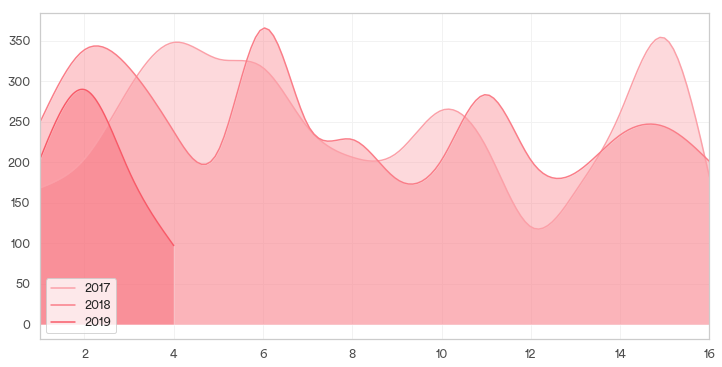

In [19]:
f, ax = plt.subplots(figsize=(12, 6))

years = [2017, 2018, 2019]

for year in years:

    x = data.loc[data['season'] == year, 'game'].values
    y = data.loc[data['season'] == year, 'passYards'].values

    sp = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=.97)

    xs = np.linspace(x[0], x[-1], 150)
    ys = sp(xs)


    ax = sns.lineplot(x=xs, y=ys, lw=1.5, label=year)
    ax.set_xlim((1,16))
    #ax.set_ylim(0)
    
    plt.fill_between(xs, ys, 0, alpha=0.4)
    
    #sns.despine(left=True, right=True, bottom=True, top=True)
    
    filename = 'test'
    
    plt.savefig('output/ngs/' + filename + '.svg', format='svg', dpi=300, bbox_inches='tight')
    

## Averages per team

In [83]:
df_ngs = df_ngs.rename(columns = {'gameId' : 'game_id'})
df_ = df_ngs.merge(df[['game_id', 'home_team', 'away_team']], how='left', on='game_id').drop_duplicates()

df_.loc[df_['home_team'] == df_['team'], 'def_team'] = df_['away_team']
df_.loc[df_['away_team'] == df_['team'], 'def_team'] = df_['home_team']

In [84]:
df_

,shortName,playerName,team,aggressiveness,attempts,avgAirYardsDifferential,avgAirYardsToSticks,avgCompletedAirYards,avgIntendedAirYards,avgTimeToThrow,...,passTouchdowns,passYards,passerRating,season,seasonType,week,game_id,home_team,away_team,def_team
0,C.Wentz,Carson Wentz,PHI,12.8,39,-0.9,-0.2,7.7,8.6,2.57,...,3,313,121.0,2019,REG,1,2019090806,PHI,WAS,WAS
185,P.Mahomes,Patrick Mahomes,KC,3.0,33,-1.4,-1.9,4.5,5.9,2.42,...,3,378,143.2,2019,REG,1,2019090802,JAX,KC,JAX
353,C.Keenum,Case Keenum,WAS,13.6,44,-1.4,-3.0,5.9,7.4,2.85,...,3,380,117.6,2019,REG,1,2019090806,PHI,WAS,PHI
538,J.Garoppolo,Jimmy Garoppolo,SF,14.8,27,-3.0,-5.7,2.2,5.2,2.31,...,1,166,80.2,2019,REG,1,2019090811,TB,SF,TB
712,R.Fitzpatrick,Ryan Fitzpatrick,MIA,24.1,29,-5.5,5.5,10.1,15.5,2.79,...,1,185,66.0,2019,REG,1,2019090803,MIA,BAL,BAL
883,R.Wilson,Russell Wilson,SEA,25.0,20,-2.6,-2.8,6.1,8.8,2.91,...,2,195,134.4,2019,REG,1,2019090808,SEA,CIN,CIN
1058,B.Roethlisberger,Ben Roethlisberger,PIT,12.8,47,-5.0,0.1,4.6,9.6,2.54,...,0,276,65.6,2019,REG,1,2019090812,NE,PIT,NE
1234,D.Brees,Drew Brees,NO,7.0,43,0.0,-0.8,7.5,7.5,2.85,...,2,370,105.8,2019,REG,1,2019090900,NO,HOU,HOU
1413,J.Flacco,Joe Flacco,DEN,16.1,31,-0.4,-0.5,7.2,7.6,2.66,...,1,268,105.3,2019,REG,1,2019090901,OAK,DEN,OAK
1572,E.Manning,Eli Manning,NYG,13.6,44,-0.7,-3.9,4.9,5.5,2.69,...,1,306,95.5,2019,REG,1,2019090810,DAL,NYG,DAL


In [87]:
df_['total_seconds'] = df_['attempts']*df_['avgTimeToThrow'] 
df_

,shortName,playerName,team,aggressiveness,attempts,avgAirYardsDifferential,avgAirYardsToSticks,avgCompletedAirYards,avgIntendedAirYards,avgTimeToThrow,...,passYards,passerRating,season,seasonType,week,game_id,home_team,away_team,def_team,total_seconds
0,C.Wentz,Carson Wentz,PHI,12.8,39,-0.9,-0.2,7.7,8.6,2.57,...,313,121.0,2019,REG,1,2019090806,PHI,WAS,WAS,100.23
185,P.Mahomes,Patrick Mahomes,KC,3.0,33,-1.4,-1.9,4.5,5.9,2.42,...,378,143.2,2019,REG,1,2019090802,JAX,KC,JAX,79.86
353,C.Keenum,Case Keenum,WAS,13.6,44,-1.4,-3.0,5.9,7.4,2.85,...,380,117.6,2019,REG,1,2019090806,PHI,WAS,PHI,125.40
538,J.Garoppolo,Jimmy Garoppolo,SF,14.8,27,-3.0,-5.7,2.2,5.2,2.31,...,166,80.2,2019,REG,1,2019090811,TB,SF,TB,62.37
712,R.Fitzpatrick,Ryan Fitzpatrick,MIA,24.1,29,-5.5,5.5,10.1,15.5,2.79,...,185,66.0,2019,REG,1,2019090803,MIA,BAL,BAL,80.91
883,R.Wilson,Russell Wilson,SEA,25.0,20,-2.6,-2.8,6.1,8.8,2.91,...,195,134.4,2019,REG,1,2019090808,SEA,CIN,CIN,58.20
1058,B.Roethlisberger,Ben Roethlisberger,PIT,12.8,47,-5.0,0.1,4.6,9.6,2.54,...,276,65.6,2019,REG,1,2019090812,NE,PIT,NE,119.38
1234,D.Brees,Drew Brees,NO,7.0,43,0.0,-0.8,7.5,7.5,2.85,...,370,105.8,2019,REG,1,2019090900,NO,HOU,HOU,122.55
1413,J.Flacco,Joe Flacco,DEN,16.1,31,-0.4,-0.5,7.2,7.6,2.66,...,268,105.3,2019,REG,1,2019090901,OAK,DEN,OAK,82.46
1572,E.Manning,Eli Manning,NYG,13.6,44,-0.7,-3.9,4.9,5.5,2.69,...,306,95.5,2019,REG,1,2019090810,DAL,NYG,DAL,118.36


In [98]:
data = df_.groupby(['season', 'def_team'])['total_seconds', 'attempts'].sum().reset_index()
data['avgttt'] = data['total_seconds'] / data['attempts']

In [99]:
data[data['season'] == 2018].sort_values('avgttt', ascending=True)

,season,def_team,total_seconds,attempts,avgttt
39,2018,CLE,1588.30,623,2.549438
41,2018,DEN,1425.01,547,2.605137
58,2018,PIT,1463.22,557,2.626966
36,2018,CAR,1380.75,519,2.660405
57,2018,PHI,1648.10,617,2.671151
63,2018,WAS,1358.64,505,2.690376
47,2018,KC,1685.96,625,2.697536
48,2018,LA,1414.13,524,2.698721
45,2018,IND,1425.61,528,2.700019
40,2018,DAL,1470.49,542,2.713081


In [100]:
data[data['season'] == 2019].sort_values('avgttt', ascending=True)

,season,def_team,total_seconds,attempts,avgttt
90,2019,PIT,239.99,103,2.330000
67,2019,BUF,305.34,122,2.502787
93,2019,TB,287.34,114,2.520526
66,2019,BAL,270.40,106,2.550943
68,2019,CAR,273.12,107,2.552523
65,2019,ATL,206.22,80,2.577750
95,2019,WAS,178.23,69,2.583043
91,2019,SEA,293.50,112,2.620536
69,2019,CHI,209.70,80,2.621250
88,2019,OAK,251.86,96,2.623542
